# ![image](input/USC.png)

>### HaoZhang hzhang80@usc.edu

>### RenyuWang renyuwan@usc.edu

# <a id = '9'>Catalogue:</a>
- <a href='#1'>1. Introduction: ASHRAE - Great Energy Predictor III</a>
    - <a href='#1-1'> 1.1 Data Files</a>
    - <a href='#1-2'> 1.2 Evaluation Indicator</a>
- <a href='#2'>2. Packages Importation</a>
- <a href='#3'>3. Data Importation and Compression</a>
- <a href='#4'>4. Data Analysis</a>
- <a href='#5'>5. Feature Engineering</a>
- <a href='#6'>6. Trainning Models</a>
    - <a href='#6-1'> 6.1 Classic Models</a>
    - <a href='#6-2'> 6.2 LightGBM Models</a>
- <a href='#7'>7. Feature Importance Analysis</a>
- <a href='#8'>8. Predicting and Output</a><a id='9'></a>

# <a id = '1'>Introduction: ASHRAE - Great Energy Predictor III </a>

> In real life, many buildings need to consume energy. For example, in summer, air conditioning is required to cool. This not only brings economic expenditure, but also has a bad impact on the environment. To reduce energy consumption, we need to predict the energy use of buildings. The competition will predict energy usage by combining weather data, building data, and hot water and cold water energy consumption data. The following is the description of the official website.

>在现实生活中，很多建筑物需要消耗能源，比如说夏天的时候，需要空调来进行制冷。这不仅仅带来了经济支出，还对环境造成了不好的影响。为了减少能源的消耗，我们需要对建筑物的能源使用进行预测。本次比赛将通过结合天气数据，建筑数据，以及热水，冷水能源消耗数据来预测能源使用量。下面是官网的描述。

### How much energy will a building consume?

    
* Q: How much does it cost to cool a skyscraper in the summer?
* A: A lot! And not just in dollars, but in environmental impact.

Thankfully, significant investments are being made to improve building efficiencies to reduce costs and emissions. So, are the improvements working? That’s where you come in. Current methods of estimation are fragmented and do not scale well. Some assume a specific meter type or don’t work with different building types.

Developing energy savings has two key elements: Forecasting future energy usage without improvements, and forecasting energy use after a specific set of improvements have been implemented, like the installation and purchase of investment-grade meters, whose prices continue to fall. One issue preventing more aggressive growth of the energy markets are the lack of cost-effective, accurate, and scalable procedures for forecasting energy use.

In this competition, you’ll develop accurate predictions of metered building energy usage in the following areas: chilled water, electric, natural gas, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe.

With better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.


   Founded in 1894, [ASHRAE](https://www.kaggle.com/orgs-under-maintenance) serves to advance the arts and sciences of heating, ventilation, air conditioning refrigeration and their allied fields. ASHRAE members represent building system design and industrial process professionals around the world. With over 54,000 members serving in 132 countries, ASHRAE supports research, standards writing, publishing and continuing education - shaping tomorrow’s built environment today.

## <a id='1-1'>1.1 Data Files</a> (<a href='#9'>TOP</a>)

### Files
> Here are the files used in this competition:

<b>train.csv</b>

* building_id - Foreign key for the building metadata.
* meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
* timestamp - When the measurement was taken
* meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with * measurement error, which we expect will impose a baseline level of modeling error.

<b> building_meta.csv</b>
* site_id - Foreign key for the weather files.
* building_id - Foreign key for training.csv
* primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
* square_feet - Gross floor area of the building
* year_built - Year building was opened
* floor_count - Number of floors of the building

<b>weather_[train/test].csv</b>
Weather data from a meteorological station as close as possible to the site.

* site_id
* air_temperature - Degrees Celsius
* cloud_coverage - Portion of the sky covered in clouds, in oktas
* dew_temperature - Degrees Celsius
* precip_depth_1_hr - Millimeters
* sea_level_pressure - Millibar/hectopascals
* wind_direction - Compass direction (0-360)
* wind_speed - Meters per second

<b>test.csv</b>

The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.

* row_id - Row id for your submission file
* building_id - Building id code
* meter - The meter id code
* timestamp - Timestamps for the test data period

<b>sample_submission.csv</b>

A valid sample submission.

* All floats in the solution file were truncated to four decimal places; we recommend you do the same to save space on your file upload.
* There are gaps in some of the meter readings for both the train and test sets. Gaps in the test set are not revealed or scored.

## <a id='1-2'>1.2 Evaluation Indicator</a> (<a href='#9'>TOP</a>)

The evaluation indicators for this competition are: RMSLE (Root Mean Squared Logarithmic Error)

We can use this package:

>from sklearn.metrics import mean_squared_log_error
loss=np.sqrt(mean_squared_log_error( y_test, predictions))

# <a id='2'>2. Packages Importation</a> (<a href='#9'>TOP</a>)

In [35]:
import random
import datetime
import os,gc,math
import numpy as np 
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
%matplotlib inline

# <a id='3'>3. Data Importation and Compression</a> (<a href='#9'>TOP</a>)

In [59]:
%%time
data_path = r'D:\StudyMaterial\USC\Semester2_19fall\EE660\PROJECT/input/ashrae-energy-prediction/'
train_df = pd.read_csv(data_path + 'train.csv')
test_df = pd.read_csv(data_path + 'test.csv')
weather_train_df = pd.read_csv(data_path + 'weather_train.csv')
weather_test_df = pd.read_csv(data_path + 'weather_test.csv')
building_meta_df = pd.read_csv(data_path + 'building_metadata.csv')
sample_submission = pd.read_csv(data_path + 'sample_submission.csv')

Wall time: 1min 58s


In [37]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [38]:
train_df.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype='object')

In [39]:
## 压缩数据(这个看情况，如果内存大可以不用，效果会差一点点)
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [40]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)


# <a id='4'>4. Data Analysis</a> (<a href='#9'>TOP</a>)

In [41]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [42]:
test_df.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [43]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [44]:
weather_test_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [45]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


## <a id='4-1'>4.1 Data Type Analysis</a> (<a href='#9'>TOP</a>)

In [46]:
train_df.dtypes

building_id        int16
meter               int8
timestamp         object
meter_reading    float32
dtype: object

In [47]:
weather_train_df.dtypes

site_id                 int64
timestamp              object
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtype: object

In [48]:
building_meta_df.dtypes

site_id          int64
building_id      int64
primary_use     object
square_feet      int64
year_built     float64
floor_count    float64
dtype: object

## <a id='4-2'>4.2 Target Value Analysis</a> (<a href='#9'>TOP</a>)

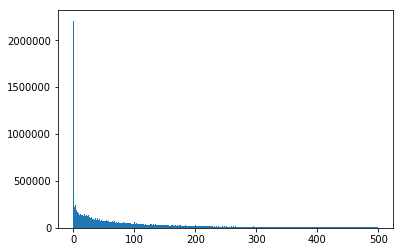

In [49]:
# 目标值的分布
a=plt.hist(train_df['meter_reading'],range(0,500))

In [50]:
train_df.groupby(["meter"])["meter_reading"].agg(['mean','std'])

,mean,std
meter,,
0,170.825638,380.834290
1,633.363953,7988.212891
2,13882.187500,418313.500000
3,385.866791,2508.172607


## <a id='4-3'>4.3 Correlation Analysis</a> (<a href='#9'>TOP</a>)

In [51]:
import seaborn as sns

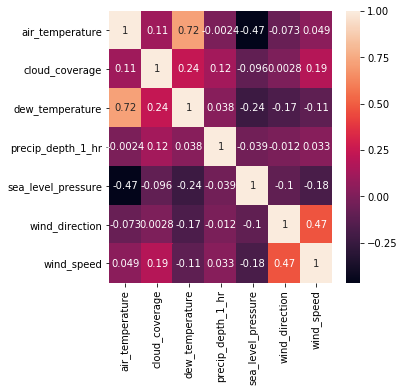

In [52]:
# (weather)
num_cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed' ]
plt.figure(figsize=(5,5))
sns.heatmap(weather_train_df[num_cols].dropna(inplace=False).corr(),annot=True)

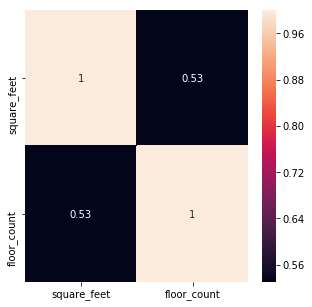

In [53]:
#(building)
num_cols2 = ['square_feet','floor_count']
plt.figure(figsize=(5,5))
sns.heatmap(building_meta_df[num_cols2].dropna(inplace=False).corr(),annot=True)

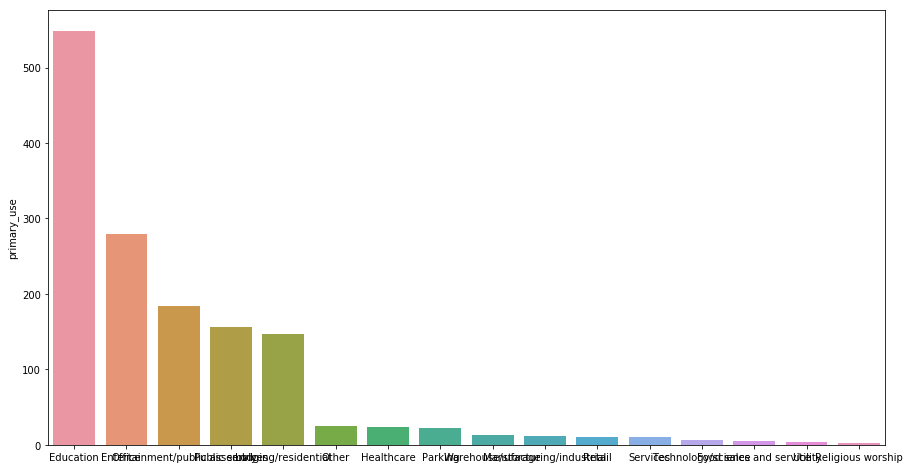

In [54]:
# distribution of primary_use
plt.figure(figsize = (15,8))
data = building_meta_df['primary_use'].value_counts()
sns.barplot(data.index,data)

# <a id='5'>5. Feature Engineering</a> (<a href='#9'>TOP</a>)

In [55]:
def fill_weather_dataset(weather_df):
    
    # 根据最大时期和最小时期的差，计算最多有多少个小时
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]
    
    # 把消失的小时加入到里面去
    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # 添加新的特征day, week,month
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # 重新设置Index
    weather_df = weather_df.set_index(['site_id','day','month'])
    
    # 根据地点，日期，和月把缺少的温度补全
    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # 根据地点，日期，和月把缺少的云层覆盖率补全
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])
    weather_df.update(cloud_coverage_filler,overwrite=False)
    
    # 根据地点，日期，和月把缺少的露水温度补全
    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # 根据地点，日期，和月把海拔给补全
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])
    weather_df.update(sea_level_filler,overwrite=False)
    
    # 风的方向，补全
    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)
    
    # 风速补全
    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # 降雨量补全
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])
    weather_df.update(precip_depth_filler,overwrite=False)
    
    # 删掉一些列
    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df

In [56]:
# 加一些累计的特征(window = 24表示，24小时内的平均温度)
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby(['site_id','building_id'])
    cols = ['air_temperature'] 
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
#     lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
#         weather_df[f'{col}_std_lag{window}'] = lag_mean[col]

# 加入一些频率特征
def encode_FE(df,cols):
    for col in cols:
        vc = df[col].value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df[nm] = df[col].map(vc)
        df[nm] = df[nm].astype('float16')
        print(nm,', ',end='')
        
# 加一些特征工程        
def features_engineering(df,categorical_features):
    
    # 按照timeStamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # 加入时间特征
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    
    # 加入假日特征
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                    "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                    "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                    "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                    "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                    "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                    "2019-01-01"]
    df["is_holiday"] = (df.timestamp.isin(holidays)).astype(int)
    
    # 面积
    df['square_feet'] =  np.log1p(df['square_feet'])
    # primary_use的使用频率
    encode_FE(df,['primary_use'])
    
    # 舍弃掉一些特征
    drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Label encode
    for c in categorical_features:
        le = LabelEncoder()
        df[c] = le.fit_transform(df[c])
    add_lag_feature(df,24)
    return df

In [60]:
# 有一段时间的一些房子的数据有问题，是异常值得删掉
train_df = train_df [ train_df['building_id'] != 1099 ]
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')
weather_train_df = fill_weather_dataset(weather_train_df)
train_df = train_df.merge(building_meta_df, left_on='building_id',right_on='building_id',how='left')
train_df = train_df.merge(weather_train_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
train_df = features_engineering(train_df,['primary_use','primary_use_FE'])
train_df.head(10)

# weather_train_df = reduce_mem_usage(weather_train_df)
# weather_test_df = reduce_mem_usage(weather_test_df)
train_df = reduce_mem_usage(train_df)
train_df.to_pickle("input/train.pickle")
del train_df, weather_train_df
gc.collect()

row_ids = test_df["row_id"]
test_df.drop("row_id", axis=1, inplace=True)
weather_test_df = fill_weather_dataset(weather_test_df)
test_df = test_df.merge(building_meta_df, left_on='building_id',right_on='building_id',how='left')
test_df = test_df.merge(weather_test_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
test_df = features_engineering(test_df,['primary_use','primary_use_FE'])
test_df.head(10)
test_df = reduce_mem_usage(test_df)
test_df.to_pickle("input/test.pickle")
del test_df, weather_test_df
gc.collect()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


primary_use_FE , Mem. usage decreased to 624.78 Mb (71.1% reduction)
primary_use_FE , Mem. usage decreased to 1153.21 Mb (72.6% reduction)


84

# <a id='6'>6. Trainning Models</a> (<a href='#9'>TOP</a>)

## <a id='6-1'>6.1. Classic Models</a> (<a href='#9'>TOP</a>)

In [61]:
train_df = pd.read_pickle("input/train.pickle")
test_df = pd.read_pickle("input/test.pickle")

In [10]:
train_df.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,weekend,is_holiday,primary_use_FE,air_temperature_mean_lag24
0,105,0,23.303600,1,0,10.835938,3.800781,0.0,2.400391,0.0,0,4,1,15,26.093750
1,106,0,0.374600,1,0,8.585938,3.800781,0.0,2.400391,0.0,0,4,1,15,25.546875
2,106,3,0.000000,1,0,8.585938,3.800781,0.0,2.400391,0.0,0,4,1,15,24.640625
3,107,0,175.184006,1,0,11.484375,3.800781,0.0,2.400391,0.0,0,4,1,15,24.171875
4,108,0,91.265297,1,0,11.312500,3.800781,0.0,2.400391,0.0,0,4,1,15,23.906250


In [62]:
kf = KFold(n_splits=3)

In [67]:
scaled_features = features.copy()
scaled_features.value= StandardScaler().fit_transform(features)

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int8, float16, int16 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int8, float16, int16 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [68]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend","primary_use_FE"]
selected_features = ['building_id',
 'meter',
 'site_id',
 'primary_use',
 'square_feet',
 'primary_use_FE',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'hour',
 'weekend',
 'air_temperature_mean_lag24']
target = np.log1p(train_df["meter_reading"])
features = train_df[selected_features]

In [74]:
def classic_model_fit(X,y,model_name, kf,params=None):
    i = 0;
    models = []
    losses = []
    for train_index,test_index in kf.split(X):
        train_features = X.loc[train_index]
        train_target = y.loc[train_index]
        test_features = X.loc[test_index]
        test_target = y.loc[test_index]
        if model_name == "lasso":
            model = Lasso() if params==None else Lasso(params)
        elif model_name == "ridge":
            model = Ridge() if params == None else Ridge(params)
        elif model_name == "linearRegression":
            model = LinearRegression() if params == None else LinearRegression(params)
        #这个得算很久
        elif model_name == "svm":
            model = LinearSVR() if params == None else LinearSVR(params)
        model.fit(train_features,train_target)
        rmse = math.sqrt(mean_squared_error(test_target,model.predict(test_features))) 
        print("fold %d: RMSE loss %f"%(i,rmse))
        models.append(model)
        losses.append(rmse)
        i+=1
    print(model_name, "CV RMSE Loss:",np.mean(losses))
    return models

In [60]:
lasso_models = classic_model_fit(scaled_features,target,"lasso",kf)

fold 0: RMSE loss 2.069463
fold 1: RMSE loss 2.029070
fold 2: RMSE loss 2.059877
lasso CV RMSE Loss: 2.0528032395509377


In [61]:
ridge_models = classic_model_fit(scaled_features,target,"ridge",kf)

fold 0: RMSE loss 1.894620
fold 1: RMSE loss 1.826174
fold 2: RMSE loss 1.844988
ridge CV RMSE Loss: 1.855260181167749


In [10]:
linearRegression_models = classic_model_fit(scaled_features,target,"linearRegression",kf)

fold 0: RMSE loss 1.894622
fold 1: RMSE loss 1.826170
fold 2: RMSE loss 1.844986
linearRegression CV RMSE Loss: 1.8552591924839967


In [ ]:
SVM_models = classic_model_fit(scaled_features,target,"svm",kf)

## <a id='6-2'>6.2 LightGBM Model</a> (<a href='#9'>TOP</a>)

In [69]:
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
    "random_seed":10
}

models = []
history = []
for train_index,test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000,valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

D:\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.12669	valid_1's rmse: 1.26937
[50]	training's rmse: 0.909941	valid_1's rmse: 1.13984
[75]	training's rmse: 0.832763	valid_1's rmse: 1.1169
[100]	training's rmse: 0.792983	valid_1's rmse: 1.11799
[125]	training's rmse: 0.764071	valid_1's rmse: 1.12086
Early stopping, best iteration is:
[82]	training's rmse: 0.819948	valid_1's rmse: 1.11624


D:\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.13221	valid_1's rmse: 1.2366
[50]	training's rmse: 0.914312	valid_1's rmse: 1.07788
[75]	training's rmse: 0.843477	valid_1's rmse: 1.04301
[100]	training's rmse: 0.807414	valid_1's rmse: 1.03101
[125]	training's rmse: 0.783747	valid_1's rmse: 1.029
[150]	training's rmse: 0.765844	valid_1's rmse: 1.02909
[175]	training's rmse: 0.75399	valid_1's rmse: 1.02952
Early stopping, best iteration is:
[130]	training's rmse: 0.780127	valid_1's rmse: 1.02875


D:\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.10113	valid_1's rmse: 1.27656
[50]	training's rmse: 0.864559	valid_1's rmse: 1.15737
[75]	training's rmse: 0.781427	valid_1's rmse: 1.14431
[100]	training's rmse: 0.742274	valid_1's rmse: 1.1477
Early stopping, best iteration is:
[73]	training's rmse: 0.78462	valid_1's rmse: 1.14392


In [70]:
cv_scores = np.mean([model.best_score['valid_1']['rmse'] for model in models])
cv_scores

1.0963024754230517

# <a  id='7'>7. Feature Importance Analysis</a> (<a href='#9'>TOP</a>)

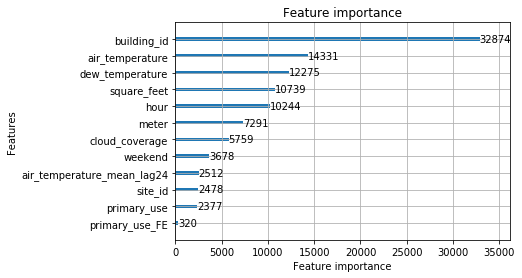

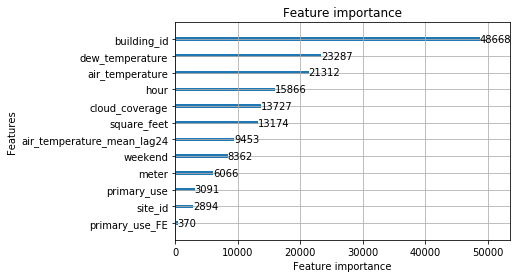

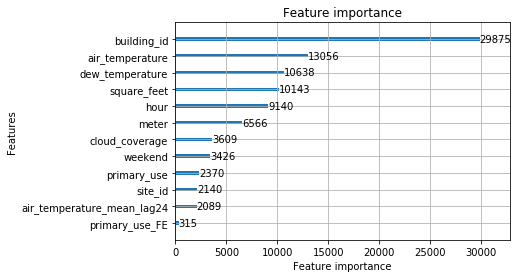

In [71]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

# <a  id='8'>8. Predicting and Output</a> (<a href='#9'>TOP</a>)

In [72]:
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test_df[selected_features], num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_df[selected_features], num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [73]:
results_df = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(results, 0, a_max=None)})
##del row_ids,results, test_df, models
##gc.collect()

results_df.to_csv("submission.csv", index=False,float_format='%.4f')
results_df.head(20)

,row_id,meter_reading
0,0,172.754876
1,1,75.255555
2,2,8.342091
3,3,255.031400
4,4,786.652916
5,5,17.175440
6,6,99.872649
7,7,395.208988
8,8,323.930707
9,9,330.263203
